# Analytics: Travel Insurance
### Created By : Eldwin Surya Kusuma W


In [4]:
!pip install category_encoders
!pip install catboost
# !pip uninstall scikit-learn imbalanced-learn
# !pip install scikit-learn imbalanced-learn

## Business Problem Understanding

**Context**  
Suatu perusahaan yang bergerak di bidang asuransi perjalanan ingin mengetahui pemegang polis yang akan mengajukan klaim asuransi untuk pertanggungan. Data pemegang polis pada perusahaan asuransi merupakan data historis yang terdiri dari destinasi, produk asuransi, dan sebagainya.

Target :

0 : Tidak mengajukan klaim asuransi

1 : Mengajukan klaim asuransi

**Problem Statement :**

Perusahaan ingin mengetahui customer mana saja yang akan mengajukan klaim asuransi untuk pertanggungan

**Goals :**

Maka berdasarkan permasalahan tersebut, perusahaan ingin memiliki kemampuan untuk memprediksi customer yang akan mengajukan klaim asuransi atau tidak, sehingga dapat mempersiapkan dana yang dibutuhkan perusahaan tersebut.

Dan juga perusahaan ingin mengetahui apa/faktor/variabel apa yang membuat customer biasanya melakukan klaim asuransi atau tidak, sehingga perusahaan dapat melakukan persiapan dana untuk pencairan asuransi.

**Analytic Approach :**

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan customer mana yang biasanya akan melakukan klaim asuransi dan yang tidak.

Kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas customer yang akan melakukan klaim asuransi atau tidak.

**Metric Evaluation**

Kita ingin membuat model yang dapat memprediksi customer mana yang akan melakukan claim asuransi.

Jadi nanti metric utama yang akan kita gunakan adalah roc_auc

## Data Understanding

Dataset source : https://drive.google.com/drive/folders/1iVx5k6tWglqfHb05o0DElg8JHg7VVG_J

Note :
- Dataset tidak seimbang
- Sebagian besar fitur bersifat kategori (Nominal, Binary), beberapa dengan kardinalitas tinggi
- Setiap baris data merepresentasikan informasi travel insurance customer

In [5]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from category_encoders import TargetEncoder

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler


# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import files
uploaded = files.upload()

Mounted at /content/drive


Saving data_travel_insurance.csv to data_travel_insurance.csv


Dataset ini berisi informasi terkait Data Asuransi Travel. Ada 11 kolom di dalam dataset Travel Insurance, yaitu:

*Travel Insurance
* Agency : Nama Agency Travel
* Agency Type : Tipe Agency Travel
* Distribution Channel : Channel yang digunakan oleh Agency Travel
* Product Name : Nama Produk Asuransi Travel
* Gender : Gender Tertanggung (Customer)
* Duration : Durasi Travel
* Destination : Destinasi Travel
* Net Sales : Total Penjualan Polis Asuransi Travel
* Commision (in value) : Komisi yang diterima oleh Agency Travel
* Age : Usia Tertanggung (Customer)
* Claim : Status Claim


Berikut 5 baris teratas dan terbawah dari dataset Travel Insurance

In [7]:
df = pd.read_csv("data_travel_insurance.csv")
display(df.head(),df.tail())

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No
44327,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,172,SINGAPORE,0.0,17.82,31,No


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


## Data Cleaning

In [9]:
#Melihat data unik dan kosong

pd.set_option('display.max_colwidth', -1)
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), df[col].unique()]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueALL'],
                     data=listItem)
dfDesc

<ipython-input-9-88aeb74960bb>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,dataFeatures,dataType,null,nullPct,unique,uniqueALL
0,Agency,object,0,0.00,16,"[C2B, EPX, JZI, CWT, LWC, ART, CSR, SSI, RAB, KML, TST, TTW, JWT, ADM, CCR, CBH]"
1,Agency Type,object,0,0.00,2,"[Airlines, Travel Agency]"
2,Distribution Channel,object,0,0.00,2,"[Online, Offline]"
3,Product Name,object,0,0.00,26,"[Annual Silver Plan, Cancellation Plan, Basic Plan, 2 way Comprehensive Plan, Bronze Plan, 1 way Comprehensive Plan, Rental Vehicle Excess Insurance, Single Trip Travel Protect Gold, Silver Plan, Value Plan, 24 Protect, Annual Travel Protect Gold, Comprehensive Plan, Ticket Protector, Travel Cruise Protect, Single Trip Travel Protect Silver, Individual Comprehensive Plan, Gold Plan, Annual Gold Plan, Child Comprehensive Plan, Premier Plan, Annual Travel Protect Silver, Single Trip Travel Protect Platinum, Annual Travel Protect Platinum, Spouse or Parents Comprehensive Plan, Travel Cruise Protect Family]"
4,Gender,object,31647,71.39,2,"[F, nan, M]"
5,Duration,int64,0,0.00,437,"[365, 4, 19, 20, 8, 2, 25, 90, 24, 43, 103, 376, 6, 16, 27, 34, 3, 14, 12, 31, 5, 7, 56, 29, 30, 58, 9, 38, 42, 11, 13, 40, 79, 370, 366, 26, 83, 55, 18, 100, 1, 35, 36, 75, 23, 73, 32, 232, 37, 10, 4736, 15, 17, 99, 173, 74, 82, 66, 156, 39, 95, 98, 111, 430, 53, 77, 87, 70, 151, 45, 54, 114, 118, 62, 28, 112, 326, 22, 59, 44, 21, 97, 63, 60, 51, 180, 160, 368, 65, 93, 71, 57, 0, 76, 69, 110, 146, 116, 129, 84, ...]"
6,Destination,object,0,0.00,138,"[SINGAPORE, MALAYSIA, INDIA, UNITED STATES, KOREA, REPUBLIC OF, THAILAND, GERMANY, JAPAN, INDONESIA, VIET NAM, AUSTRALIA, FINLAND, UNITED KINGDOM, SRI LANKA, SPAIN, HONG KONG, MACAO, CHINA, UNITED ARAB EMIRATES, IRAN, ISLAMIC REPUBLIC OF, TAIWAN, PROVINCE OF CHINA, POLAND, CANADA, OMAN, PHILIPPINES, GREECE, BELGIUM, TURKEY, BRUNEI DARUSSALAM, DENMARK, SWITZERLAND, NETHERLANDS, SWEDEN, MYANMAR, KENYA, CZECH REPUBLIC, FRANCE, RUSSIAN FEDERATION, PAKISTAN, ARGENTINA, TANZANIA, UNITED REPUBLIC OF, SERBIA, ITALY, CROATIA, NEW ZEALAND, PERU, MONGOLIA, CAMBODIA, QATAR, NORWAY, LUXEMBOURG, MALTA, LAO PEOPLE'S DEMOCRATIC REPUBLIC, ISRAEL, SAUDI ARABIA, AUSTRIA, PORTUGAL, NEPAL, UKRAINE, ESTONIA, ICELAND, BRAZIL, MEXICO, CAYMAN ISLANDS, PANAMA, BANGLADESH, TURKMENISTAN, BAHRAIN, KAZAKHSTAN, TUNISIA, IRELAND, ETHIOPIA, NORTHERN MARIANA ISLANDS, MALDIVES, SOUTH AFRICA, VENEZUELA, COSTA RICA, JORDAN, MALI, CYPRUS, MAURITIUS, LEBANON, KUWAIT, AZERBAIJAN, HUNGARY, BHUTAN, BELARUS, MOROCCO, ECUADOR, UZBEKISTAN, CHILE, FIJI, PAPUA NEW GUINEA, ANGOLA, FRENCH POLYNESIA, NIGERIA, MACEDONIA, THE FORMER YUGOSLAV REPUBLIC OF, NAMIBIA, GEORGIA, COLOMBIA, ...]"
7,Net Sales,float64,0,0.00,1006,"[216.0, 10.0, 22.0, 112.0, 16.0, 50.0, 78.0, 80.0, 40.0, 26.0, 252.85, 47.0, 25.0, 23.0, 20.0, 30.0, 42.0, 56.0, 19.8, 14.0, 29.7, 36.0, 31.0, 58.0, 9.9, 15.0, 21.0, 29.0, 32.0, 125.0, 48.0, 0.0, 21.04, 33.0, 204.6, 34.0, 30.55, 35.0, 49.5, 18.0, 98.0, 77.0, 69.3, 64.0, 0.32, 227.7, 48.5, -216.75, 24.0, 161.0, 99.0, 59.4, 45.0, 37.0, 44.0, 19.0, 75.0, 39.0, 17.55, -59.4, 51.0, -29.7, 80.25, 63.0, 12.0, 72.0, 53.0, 38.0, 17.0, 54.0, 69.0, 115.0, 76.3, 19.5, 29.5, 62.0, 11.0, 3.73, 79.0, 138.6, 22.5, 59.0, 5.59, 33.5, 53.25, 62.25, 93.0, -12.0, 1.03, 27.0, 56.5, 39.6, 28.0, 41.0, 97.0, 128.0, 43.0, 66.0, 26.5, 0.19, ...]"
8,Commision (in value),float64,0,0.00,915,"[54.0, 0.0, 7.7, 4.0, 9.1, 63.21, 10.5, 11.88, 17.82, 23.4, 7.5, 5.94, 43.75, 23.76, 7.36, 132.99, 9.57, 7.64, 12.25, 29.7, 6.3, 5.63, 41.58, 5.25, 0.09, 6.0, 136.62, 31.53, 54.19, 11.55, 10.15, 40.25, 59.4, 35.64, 15.75, 12.95, 28.5, 9.75, 4.39, 20.06, 18.0, 4.25, 19.07, 4.88, 7.38, 15.5, 1.05, 83.16, 14.7, 15.4, 1.57, 8.38, 13.31, 15.56, 0.29, 8.0, 36.73, 13.65, 20.3, 5.0, 10.0, 6.63, 0.05, 24.15, 29.05, 8.88, 14.0, 3.38, 15.88, 0.45, 10.89, 47.52, 0.37, 27.25, 18.13, 15.6, 70.2, 12.4, 72.94, 8.63, 4.63, 6.75, 11.25, 0.96, 53.46, 77.22, 1.13, 4.94, 1.73, 10.38, 58.45, 23.5, 6.94, 6.13, 41.42, 17.5, 13.16, 0.14, 3.23, 15.93, ...]"
9,Age,int64,0,0.00,89,"[57, 33, 26, 59, 28, 36, 2

###Perbaikan Kolom Gender
Ada data yang hilang/kosong dikolom Gender, kita akan memperbaiki data yang kosong dan membuatnya menjadi siap pakai untuk melakukan analisa terhadap masalahnya dan juga pembuatan model machine learningnya.

Kita mengisi value kosong pada kolom Gender dengan "No Gender"

In [10]:
df['Gender'].fillna("No Gender",inplace = True)

Value yang kosong di kolom Gender, mayoritas terdapat pada Product Name = 1 way Comprehensive Plan, 2 way Comprehensive Plan, Rental Vehicle Insurance, dan Ticket Protector.

Hal ini dapat kita simpulkan bahwa pada ke empat Product Name diatas tidak memerlukan data Gender untuk melakukan input data

In [11]:
crosstab = pd.crosstab(df['Gender'],df['Product Name'])
print(crosstab)

Product Name  1 way Comprehensive Plan  2 way Comprehensive Plan  24 Protect  \
Gender                                                                         
F             0                         0                         48           
M             0                         0                         122          
No Gender     2336                      9341                      2            

Product Name  Annual Gold Plan  Annual Silver Plan  \
Gender                                               
F             64                537                  
M             78                438                  
No Gender     0                 0                    

Product Name  Annual Travel Protect Gold  Annual Travel Protect Platinum  \
Gender                                                                     
F             32                          12                               
M             31                          22                               
No Gender     0         

###Hapus Kolom Gender

*Noted = kolom Gender akan kita hapus, karena sekarang kita tahu bahwa tidak semua product travel asuransi memerlukan data gender. Dan supaya analisa kita tidak melakukan diskriminasi terhadap gender.



Sudah tidak ada kolom yang memiliki missing value

In [12]:
df.drop(['Gender'],axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Duration              44328 non-null  int64  
 5   Destination           44328 non-null  object 
 6   Net Sales             44328 non-null  float64
 7   Commision (in value)  44328 non-null  float64
 8   Age                   44328 non-null  int64  
 9   Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 3.4+ MB


###Pengelompokan Kolom Age
Pada kolom Age terdapat error data, dimana age yang diinputkan ada yang melebihi 110 tahun terdapat sebanyak 676 data (kita asumsikan sebagai lansia)


Kita akan membuat kolom baru bernama Group_Age untuk mengelompokan usia customer

Pengelompokan usia menurut Permenkes No 25. Tahun 2019 :
 - Usia Anak : 0 - 10 thn
 - Usia Remaja : 10 - 19 thn
 - Usia Dewasa : 19 - 44 thn
 - Usia Pra Lanjut Usia : 45 - 59 thn
 - Usia Lansia : >=60 thn

Source : https://gaya.tempo.co/read/1724197/kategori-umur-balita-remaja-dan-dewasa-menurut-kemenkes-jangan-salah#:~:text=Klasifikasi%20Usia%20Menurut%20WHO&text=%2D%20Usia%20muda%3A%2025%2D44,pikun%3A%2075%2D90%20tahun.

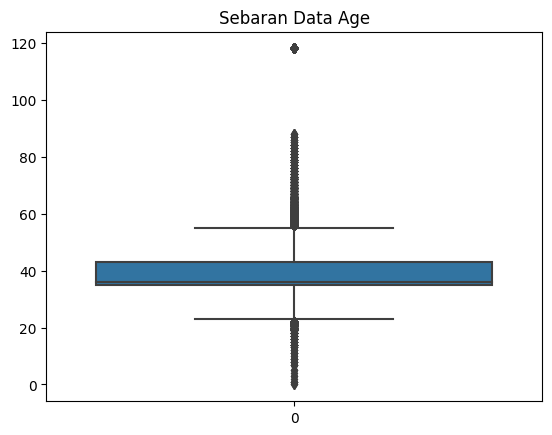

Ditemukan data umur yang melebihi 110 tahun sebanyak 676 data


In [14]:
sns.boxplot(df['Age'])
plt.title("Sebaran Data Age")
plt.show()


print(f"Ditemukan data umur yang melebihi 110 tahun sebanyak {df[df['Age']>=110]['Age'].count()} data")

In [15]:
#Membuat kolom baru Group_Age
conditions = [df['Age']<=10,df['Age']<=19,df['Age']<=44,df['Age']<=59,df['Age']>59]
result = ['Anak','Remaja','Dewasa','Pra Lanjut Usia','Lansia']

df['Group_Age'] = np.select(conditions,result, default='Error')
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Age,Claim,Group_Age
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,57,No,Pra Lanjut Usia
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,33,No,Dewasa
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,26,No,Dewasa
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,59,No,Pra Lanjut Usia
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,28,No,Dewasa
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,36,Yes,Dewasa
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,47,No,Pra Lanjut Usia
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,50,No,Pra Lanjut Usia
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,36,No,Dewasa


Setelah kita buat kolom `Group_Age`, kita akan menghapus kolom `Age` dikarenakan data didalam kolom `Age` sudah diwakilkan oleh kolom `Group_Age`

In [16]:
df.drop(['Age'],axis=1, inplace=True)

###Pengelompolan Kolom Duration
Didalam kolom Durasi ditemukan ada 2 data yang nilainya -1.


In [17]:
print(df[df['Duration']<0]['Duration'])

26228   -1
26494   -1
Name: Duration, dtype: int64


Data error -1 pada kolom durasi akan kita ubah menjadi 0 dengan asumsi durasi travel insurance -1 tidak melewati hari atau sama dengan durasi 0.

In [18]:
df['Duration'] = df['Duration'].replace(-1,0)

print(df.iloc[26228]['Duration'])
print(df.iloc[26494]['Duration'])

0
0


Didalam kolom Durasi ditemukan ada 13 data yang besar lebih dari 4500 days.
Kita asumsikan 13 data ini kemungkinan adalah kesalahan input, dan akan kita hapus.

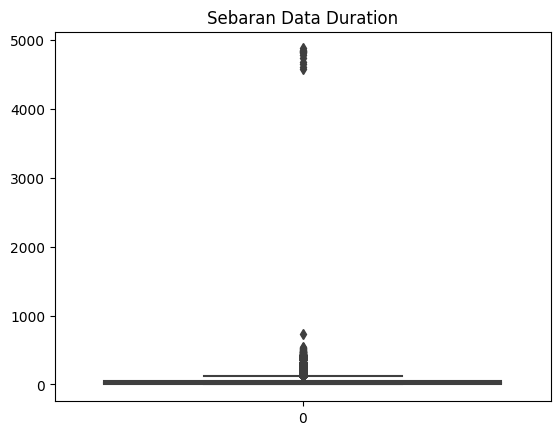

Ditemukan data Duration yang melebihi 4500 days sebanyak 13 data


In [19]:
sns.boxplot(df['Duration'])
plt.title("Sebaran Data Duration")
plt.show()

print(f"Ditemukan data Duration yang melebihi 4500 days sebanyak {df[df['Duration']>=4500]['Duration'].count()} data")

df = df.drop(df[df['Duration'] > 4500].index)

Kita juga akan membuat kolom baru bernama Group_Duration untuk mengelompokan durasi travel agar mempermudah dalam melakukan analisa

Pengelompokan durasi travel sebagai berikut :
 - 1-3 month : 0 - 90 days
 - 4-6 month : 91 - 180 days
 - 7-9 month : 181 - 270 days
 - 10-12 month : 271 - 360 days
 - '>12 month : >361 days

In [20]:
#Membuat kolom baru Group Duration
conditions = [df['Duration']<=90,df['Duration']<=180,df['Duration']<=270,df['Duration']<=360,df['Duration']>360]
result = ['1-3 month','4-6 month','7-9 month','10-12 month','>12 month']

df['Group_Duration'] = np.select(conditions,result, default='Error')
df

,Agency,Agency Type,Distribution Channel,Product Name,Duration,Destination,Net Sales,Commision (in value),Claim,Group_Age,Group_Duration
0,C2B,Airlines,Online,Annual Silver Plan,365,SINGAPORE,216.0,54.00,No,Pra Lanjut Usia,>12 month
1,EPX,Travel Agency,Online,Cancellation Plan,4,MALAYSIA,10.0,0.00,No,Dewasa,1-3 month
2,JZI,Airlines,Online,Basic Plan,19,INDIA,22.0,7.70,No,Dewasa,1-3 month
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,20,UNITED STATES,112.0,0.00,No,Pra Lanjut Usia,1-3 month
4,C2B,Airlines,Online,Bronze Plan,8,SINGAPORE,16.0,4.00,No,Dewasa,1-3 month
...,...,...,...,...,...,...,...,...,...,...,...
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,14,CHINA,30.0,0.00,Yes,Dewasa,1-3 month
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,17,AUSTRALIA,79.2,47.52,No,Pra Lanjut Usia,1-3 month
44325,TST,Travel Agency,Offline,Travel Cruise Protect,64,THAILAND,30.0,10.50,No,Pra Lanjut Usia,1-3 month
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,51,CHINA,36.0,0.00,No,Dewasa,1-3 month


Setelah kita buat kolom `Group_Duration`, kita akan menghapus kolom `Duration` dikarenakan data didalam kolom `Duration` sudah diwakilkan oleh kolom `Group_Duration`

In [21]:
df.drop(['Duration'],axis=1, inplace=True)

###Pembersihan kolom Net Sales
Terdapat 10 data Net Sales < 0, kemungkinan ini adalah kesalahan input
Jadi akan kita hapus ke 10 data ini.

In [22]:
print(df[df['Net Sales']<0])
df = df.drop(df[df['Net Sales'] < 0].index)

      Agency    Agency Type Distribution Channel  \
94     C2B    Airlines       Online                
116    CWT    Travel Agency  Online                
121    CWT    Travel Agency  Online                
199    EPX    Travel Agency  Online                
241    CWT    Travel Agency  Online                
...    ...              ...     ...                
43694  EPX    Travel Agency  Online                
43743  CWT    Travel Agency  Online                
43751  EPX    Travel Agency  Online                
43858  EPX    Travel Agency  Online                
43922  CWT    Travel Agency  Online                

                          Product Name     Destination  Net Sales  \
94     Annual Silver Plan               SINGAPORE      -216.75      
116    Rental Vehicle Excess Insurance  AUSTRALIA      -59.40       
121    Rental Vehicle Excess Insurance  JAPAN          -29.70       
199    Cancellation Plan                HONG KONG      -12.00       
241    Rental Vehicle Excess I

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43832 entries, 0 to 44327
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                43832 non-null  object 
 1   Agency Type           43832 non-null  object 
 2   Distribution Channel  43832 non-null  object 
 3   Product Name          43832 non-null  object 
 4   Destination           43832 non-null  object 
 5   Net Sales             43832 non-null  float64
 6   Commision (in value)  43832 non-null  float64
 7   Claim                 43832 non-null  object 
 8   Group_Age             43832 non-null  object 
 9   Group_Duration        43832 non-null  object 
dtypes: float64(2), object(8)
memory usage: 3.7+ MB


## Data Analysis

In [24]:
#Sorting Data Frame Berdasarkan Group Age dan Group Duration
custom_order_duration = {'1-3 month': 1, '4-6 month': 2, '7-9 month': 3, '10-12 month': 4, '>12 month': 5}
custom_order_age = {'Anak': 1, 'Remaja': 2, 'Dewasa': 3, 'Pra Lanjut Usia': 4, 'Lansia': 5}

grouped = df.groupby(['Group_Duration', 'Group_Age'])

df['Custom_Group_Duration'] = df['Group_Duration'].map(custom_order_duration)
df['Custom_Group_Age'] = df['Group_Age'].map(custom_order_age)
df_sorted = df.sort_values(by=['Custom_Group_Duration', 'Custom_Group_Age'])
df = df_sorted.reset_index(drop = True)
df.drop(['Custom_Group_Duration','Custom_Group_Age'],axis=1, inplace=True)
df

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Net Sales,Commision (in value),Claim,Group_Age,Group_Duration
0,CSR,Travel Agency,Offline,Comprehensive Plan,MALAYSIA,29.00,9.57,No,Anak,1-3 month
1,C2B,Airlines,Online,Bronze Plan,SINGAPORE,39.00,9.75,No,Anak,1-3 month
2,C2B,Airlines,Online,Silver Plan,SINGAPORE,27.75,6.94,No,Anak,1-3 month
3,CBH,Travel Agency,Offline,Comprehensive Plan,MALAYSIA,29.00,9.57,No,Anak,1-3 month
4,C2B,Airlines,Online,Bronze Plan,SINGAPORE,20.00,5.00,No,Anak,1-3 month
...,...,...,...,...,...,...,...,...,...,...
43827,C2B,Airlines,Online,Annual Silver Plan,SINGAPORE,216.00,54.00,No,Lansia,>12 month
43828,C2B,Airlines,Online,Annual Silver Plan,SINGAPORE,216.75,54.19,No,Lansia,>12 month
43829,C2B,Airlines,Online,Annual Gold Plan,SINGAPORE,278.85,69.71,No,Lansia,>12 month
43830,LWC,Travel Agency,Online,Annual Travel Protect Silver,UNITED STATES,229.80,149.37,No,Lansia,>12 month


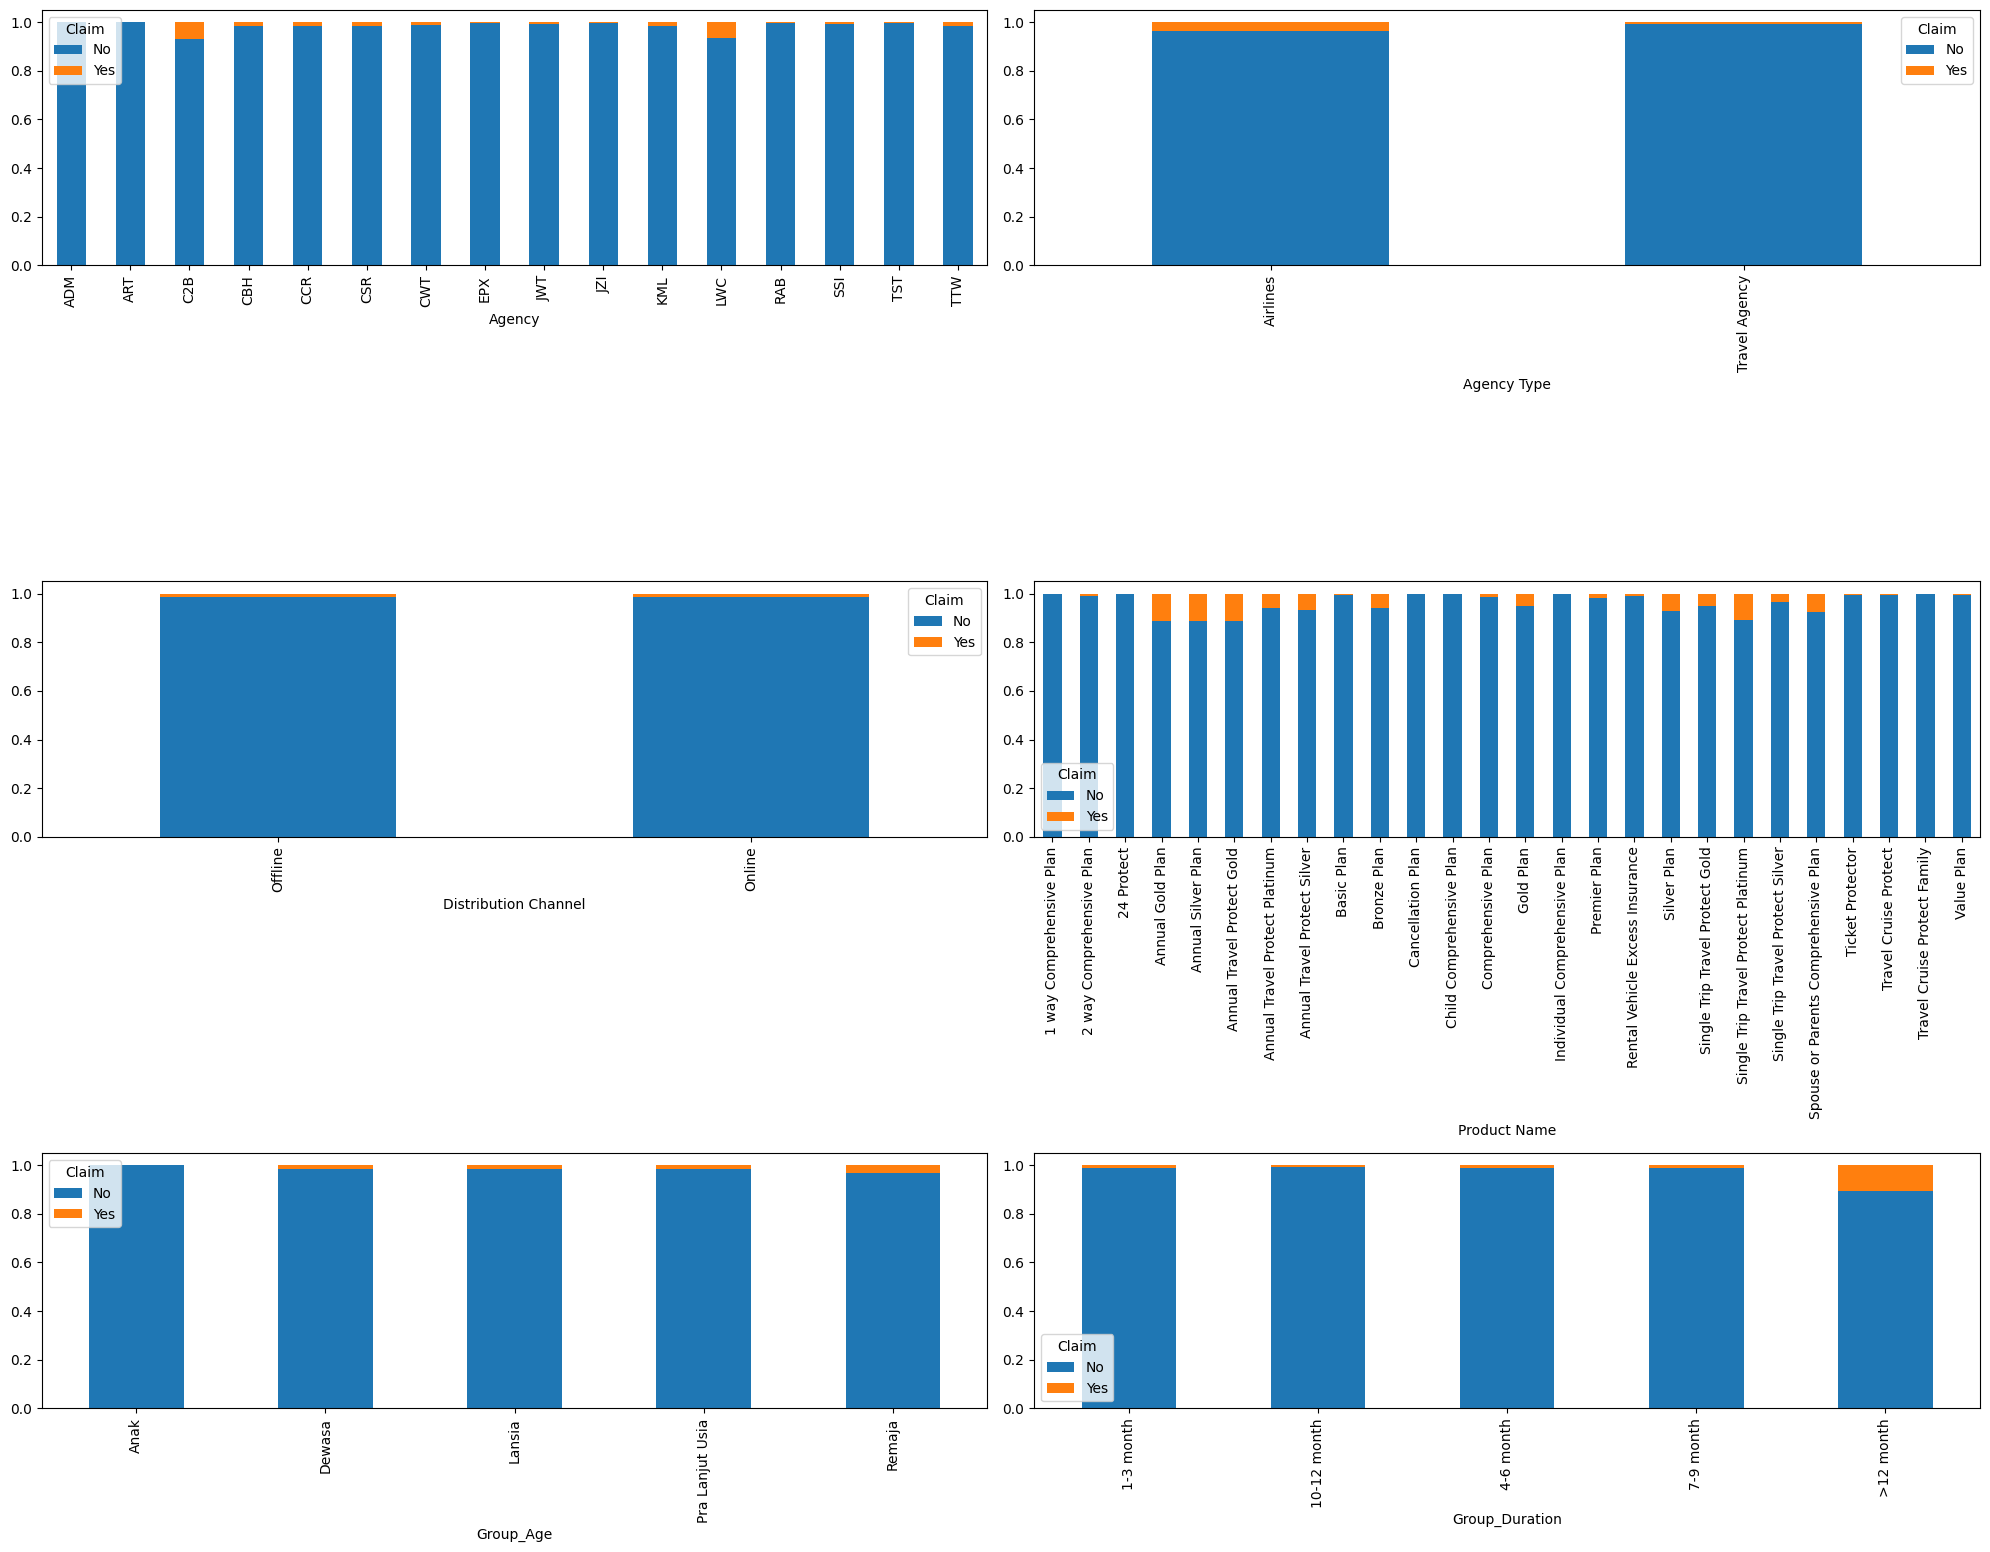

In [25]:
count = 0
fig = plt.figure(figsize=(20,20))

for i in df.drop(columns=['Destination','Net Sales','Commision (in value)','Claim']).columns:
    count +=1
    ax= plt.subplot(4,2,count)
    pd.crosstab(df[i],df['Claim'],normalize=0).plot(kind='bar',stacked=True,ax=ax)
    fig.tight_layout()

plt.show()

Berdasarkan diagram Barplot diatas kita dapat melihat adanya perbedaan yang cukup signifikan di diagram Agency, Product Name dan Group_Duration, khususnya pada kelompok >12 month

In [26]:
for i in df.drop(columns=['Destination','Net Sales','Commision (in value)','Claim']).columns:
    relevent_claim_df = df.groupby(i)['Claim'].value_counts(normalize=True).unstack()
    display(relevent_claim_df.sort_values(by=['Yes'], ascending=False))

Claim,No,Yes
Agency,,
C2B,0.928896,0.071104
LWC,0.935698,0.064302
KML,0.982143,0.017857
CCR,0.984127,0.015873
CSR,0.985294,0.014706
CBH,0.985507,0.014493
TTW,0.985507,0.014493
CWT,0.988794,0.011206
JWT,0.992263,0.007737


Claim,No,Yes
Agency Type,,
Airlines,0.963847,0.036153
Travel Agency,0.992490,0.007510


Claim,No,Yes
Distribution Channel,,
Online,0.984540,0.015460
Offline,0.985372,0.014628


Claim,No,Yes
Product Name,,
Annual Gold Plan,0.886525,0.113475
Annual Silver Plan,0.887164,0.112836
Annual Travel Protect Gold,0.888889,0.111111
Single Trip Travel Protect Platinum,0.893617,0.106383
Spouse or Parents Comprehensive Plan,0.923077,0.076923
Silver Plan,0.930097,0.069903
Annual Travel Protect Silver,0.932203,0.067797
Annual Travel Protect Platinum,0.941176,0.058824
Bronze Plan,0.942897,0.057103


Claim,No,Yes
Group_Age,,
Remaja,0.967320,0.032680
Lansia,0.982699,0.017301
Pra Lanjut Usia,0.984211,0.015789
Dewasa,0.984858,0.015142
Anak,1.000000,NaN


Claim,No,Yes
Group_Duration,,
>12 month,0.895958,0.104042
1-3 month,0.987213,0.012787
7-9 month,0.988079,0.011921
4-6 month,0.988274,0.011726
10-12 month,0.994220,0.005780


Berdasarkan barplot dan table diatas kita dapat menyimpulkan beberapa hal:  
  1. Customer yang melakukan Claim Asuransi paling banyak dari Agency C2B, meskipun secara persentase masih terbilang kecil.
  2. Customer yang melakukan Claim Asuransi lebih banyak dari Airlines di banding Travel Agency
  3. Customer yang melakukan Claim Asuransi lebih banyak menggunakan Distribution Channel Online di banding Offline, meskipun terpaut sedikit
  4. Produk Asuransi Annual Gold Plan, Annual Silver dan Annual Travel Protect Gold adalah 3 produk teratas yang paling sering dilakukan claim asuransi oleh customer
  5. Group Age Remaja paling sering melakukan Claim Asuransi dibanding Group Age yang lain
  6. Customer yang memiliki Group Duration Travel >12 month paling sering melakukan claim dibanding Group Duration yang lain.


In [27]:
relevent_destination_df = df.groupby('Destination')['Claim'].value_counts(normalize=True).unstack()
relevent_destination_df['count'] = df.groupby('Destination')['Claim'].count()
display(relevent_destination_df.sort_values(by=['Yes'], ascending=False).head(15))
# display(relevent_destination_df.sort_values(by=['Yes'], ascending=False).tail(15))

Claim,No,Yes,count
Destination,,,
COSTA RICA,0.666667,0.333333,3
CZECH REPUBLIC,0.953488,0.046512,43
SINGAPORE,0.954679,0.045321,9201
ICELAND,0.959459,0.040541,74
ISRAEL,0.968750,0.031250,32
ITALY,0.980263,0.019737,304
SOUTH AFRICA,0.981308,0.018692,107
TURKEY,0.981481,0.018519,54
FRANCE,0.981707,0.018293,328


Terlihat dari table diatas, bahwa ada perbedaan kecenderungan claim antara tujuan destinasi negara yang berbeda.

Mari kita lihat kecenderungan 4 tujuan destinasi negara dengan jumlah customer terbanyak.

In [28]:
df['Destination'].value_counts()

SINGAPORE           9201
MALAYSIA            4105
THAILAND            4095
CHINA               3373
AUSTRALIA           2495
                    ... 
LATVIA              1   
JAMAICA             1   
URUGUAY             1   
FRENCH POLYNESIA    1   
ARMENIA             1   
Name: Destination, Length: 137, dtype: int64

In [29]:
relevent_destination_df.sort_values(by=['Yes'], ascending=False).loc['SINGAPORE']

Claim
No       0.954679   
Yes      0.045321   
count    9201.000000
Name: SINGAPORE, dtype: float64

In [30]:
relevent_destination_df.sort_values(by=['Yes'], ascending=False).loc['MALAYSIA']

Claim
No       0.996102   
Yes      0.003898   
count    4105.000000
Name: MALAYSIA, dtype: float64

In [31]:
relevent_destination_df.sort_values(by=['Yes'], ascending=False).loc['THAILAND']

Claim
No       0.994139   
Yes      0.005861   
count    4095.000000
Name: THAILAND, dtype: float64

In [32]:
relevent_destination_df.sort_values(by=['Yes'], ascending=False).loc['CHINA']

Claim
No       0.990216   
Yes      0.009784   
count    3373.000000
Name: CHINA, dtype: float64

Terlihat bahwa destinasi `MALAYSIA`,`THAILAND`, dan `CHINA` memiliki kecenderungan customer yang sedikit melakukan claim asuransi , sedangkan untuk destinasi `SINGAPORE` lebih banyak customer yang melakukan claim asuransi.

Sekarang mari kita siapkan data kita untuk pembuatan model machine learning

## Data Preparation

In [33]:
df.head()

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Net Sales,Commision (in value),Claim,Group_Age,Group_Duration
0,CSR,Travel Agency,Offline,Comprehensive Plan,MALAYSIA,29.00,9.57,No,Anak,1-3 month
1,C2B,Airlines,Online,Bronze Plan,SINGAPORE,39.00,9.75,No,Anak,1-3 month
2,C2B,Airlines,Online,Silver Plan,SINGAPORE,27.75,6.94,No,Anak,1-3 month
3,CBH,Travel Agency,Offline,Comprehensive Plan,MALAYSIA,29.00,9.57,No,Anak,1-3 month
4,C2B,Airlines,Online,Bronze Plan,SINGAPORE,20.00,5.00,No,Anak,1-3 month


Sekarang mari kita melakukan fitur encoding untuk fitur2 categorical yang kita miliki.
Yang akan kita lakukan adalah :


1. Merubah fitur/kolom `Agency` menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur yang terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/ kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.
2. Merubah fitur/kolom `Agency Type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
3. Merubah fitur/kolom `Distribution Channel` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
4.  Merubah fitur/kolom `Product Name` menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur yang terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/ kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.
5.  Merubah fitur/kolom `Destination` menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur yang terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/ kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.
6.  Merubah fitur/kolom `Group_Age` menjadi integer 0-4 dengan Ordinal Encoding, karena fitur ini adalah grouping usia customer, dimana terdapat group usia anak hingga lansia.
7.  Merubah fitur/kolom `Group_Duration` menjadi integer 0-4 dengan Ordinal Encoding, karena fitur ini adalah grouping durasi travel, dimana terdapat group durasi 1-3 month hingga lebih dari 12 month

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43832 entries, 0 to 43831
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                43832 non-null  object 
 1   Agency Type           43832 non-null  object 
 2   Distribution Channel  43832 non-null  object 
 3   Product Name          43832 non-null  object 
 4   Destination           43832 non-null  object 
 5   Net Sales             43832 non-null  float64
 6   Commision (in value)  43832 non-null  float64
 7   Claim                 43832 non-null  object 
 8   Group_Age             43832 non-null  object 
 9   Group_Duration        43832 non-null  object 
dtypes: float64(2), object(8)
memory usage: 3.3+ MB


In [35]:
ordinal_mapping = [
    {'col' : 'Group_Age',
     'mapping' : {
        'Anak' : 0,
        'Remaja' : 1,
        'Dewasa' : 2,
        'Pra Lanjut Usia' : 3,
        'Lansia' : 4
    }},
    {'col' : 'Group_Duration',
     'mapping' : {
        '1-3 month' : 0,
        '4-6 month' : 1,
        '7-9 month' : 2,
        '10-12 month' : 3,
        '>12 month' : 4
    }}
]

In [36]:
transformer = ColumnTransformer([
    ('onehot', OneHotEncoder(drop='first'), ['Agency Type','Distribution Channel']),
    ('ordinal', ce.OrdinalEncoder(mapping= ordinal_mapping), ['Group_Age','Group_Duration']),
    ('binary', ce.BinaryEncoder(), ['Destination','Product Name','Agency'])
], remainder='passthrough')

In [37]:
x = df.drop(columns=['Claim']).reset_index(drop=True)
y = df['Claim'].reset_index(drop=True)

In [38]:
#Encoder kolom y menjadi 0 & 1
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Membuat Series dari array NumPy
y = pd.Series(y)
y = y.reset_index(drop=True)

In [39]:
x_train,x_test,y_train,y_test=train_test_split(x,y,stratify=y,test_size=0.3,random_state=23)

# Reset index pada data dan target
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

## Modeling & Evaluation

In [40]:
logreg = LogisticRegression(random_state=23)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=23)
rf = RandomForestClassifier(random_state=23)
xgb = XGBClassifier(random_state=23)
lgbm = lgb.LGBMClassifier(random_state=23)
gnb = GaussianNB()
cat = CatBoostClassifier(random_state=23)

In [41]:
models = [logreg,knn,dt,rf,xgb,lgbm,gnb,cat]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,x_train,y_train,cv=skfold,scoring='roc_auc')
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())

pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM','GaussianNB','CatBoost'],'mean roc_auc':rata,'sdev':std}).set_index('model').sort_values(by='mean roc_auc',ascending=False)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Output streaming akan dipotong hingga 5000 baris terakhir.
4:	learn: 0.3656538	total: 86.4ms	remaining: 17.2s
5:	learn: 0.3234857	total: 93.4ms	remaining: 15.5s
6:	learn: 0.2910626	total: 104ms	remaining: 14.8s
7:	learn: 0.2619919	total: 125ms	remaining: 15.5s
8:	learn: 0.2348221	total: 141ms	remaining: 15.5s
9:	learn: 0.2146117	total: 159ms	remaining: 15.7s
10:	learn: 0.1961919	total: 177ms	remaining: 15.9s
11:	learn: 0.1821002	total: 185ms	remaining: 15.2s
12:	learn: 0.1676454	total: 200ms	remaining: 15.2s
13:	learn: 0.1557186	total: 209ms	remaining: 14.7s
14:	learn: 0.1456822	total: 217ms	remaining: 14.2s
15:	learn: 0.1361032	total: 227ms	remaining: 14s
16:	learn: 0.1290386	total: 235ms	remaining: 13.6s
17:	learn: 0.1218853	total: 252ms	remaining: 13.7s
18:	learn: 0.1159197	total: 271ms	remaining: 14s
19:	learn: 0.1109311	total: 289ms	remaining: 14.2s
20:	learn: 0.1061806	total: 308ms	remaining: 14.4s
21:	learn: 0.1017832	total: 339ms	remaining: 15.1s
22:	learn: 0.0978739	total: 361

,mean roc_auc,sdev
model,,
CatBoost,0.795808,0.012656
Logistic Regression,0.793131,0.009691
XGBoost,0.792290,0.017231
LightGBM,0.790504,0.011755
GaussianNB,0.765691,0.012831
Random Forest,0.679506,0.019499
Decision Tree,0.633056,0.020367
KNN,0.586995,0.020081


Terlihat bahwa model CatBoost adalah yang terbaik untuk roc_aucnya dari setiap model yang menggunakan default hyperparameter.
LightGMB, XGBoost dan Logistic Regression juga memiliki hasil yang baik hampir sama dengan CatBoost

### Model Benchmarking : Test Data

In [42]:
models = [logreg,knn,dt,rf,xgb,lgbm,gnb,cat]
score_roc_auc = []

print(x_train)
print(x_test)

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    x_train,x_test


    estimator.fit(x_train,y_train)
    return(estimator,estimator.predict(x_test),x_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM','GaussianNB','CatBoost']):
    estimator,y_pred,x_test_prep_scaled = y_pred_func(i)
    y_predict_proba = estimator.predict_proba(x_test_prep_scaled)[:,1]
    score_roc_auc.append(roc_auc_score(y_test,y_predict_proba))
    print(j,'\n', classification_report(y_test,y_pred))

pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM','GaussianNB','CatBoost'],
             'roc_auc score':score_roc_auc}).set_index('model').sort_values(by='roc_auc score',ascending=False)

      Agency    Agency Type Distribution Channel  \
0      CWT    Travel Agency  Online                
1      C2B    Airlines       Online                
2      EPX    Travel Agency  Online                
3      JWT    Airlines       Online                
4      JZI    Airlines       Online                
...    ...         ...          ...                
30677  JZI    Airlines       Online                
30678  EPX    Travel Agency  Online                
30679  C2B    Airlines       Online                
30680  C2B    Airlines       Online                
30681  CWT    Travel Agency  Online                

                          Product Name Destination  Net Sales  \
0      Rental Vehicle Excess Insurance  AUSTRALIA   59.4        
1      Bronze Plan                      SINGAPORE   20.0        
2      Cancellation Plan                THAILAND    21.0        
3      Value Plan                       INDIA       100.0       
4      Basic Plan                       CAMBODIA  

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels wit

Logistic Regression 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     12947
           1       0.00      0.00      0.00       203

    accuracy                           0.98     13150
   macro avg       0.49      0.50      0.50     13150
weighted avg       0.97      0.98      0.98     13150

KNN 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     12947
           1       0.20      0.00      0.01       203

    accuracy                           0.98     13150
   macro avg       0.59      0.50      0.50     13150
weighted avg       0.97      0.98      0.98     13150

Decision Tree 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     12947
           1       0.03      0.00      0.01       203

    accuracy                           0.98     13150
   macro avg       0.51      0.50      0.50     13150
weighted avg       0.97      0

,roc_auc score
model,
XGBoost,0.800932
LightGBM,0.796250
CatBoost,0.793514
Logistic Regression,0.788263
GaussianNB,0.752474
Random Forest,0.700765
Decision Tree,0.669846
KNN,0.620611


Terlihat model XGBoost adalah yang terbaik performanya pada test data.
Hal ini lebih penting dikarenakan kinerja pada data uji mencerminkan sejauh mana model mampu mengatasi data yang tidak dikenal.

Mari sekarang kita coba melakukan oversampling untuk model XGBoost kita untuk melihat apakah kita dapat mendapatkan hasil yang lebih baik lagi.

### Test Oversampling with K-Fold Cross Validation

In [43]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    pr_auc = average_precision_score(y_train, predictProba[:, 1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return {
        'report': report,
        'f1' : f1,
        'roc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    pr_auc = average_precision_score(y_test, predictProba[:, 1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return {
        'report': report,
        'f1' : f1,
        'roc': roc_auc,
        'pr_auc': pr_auc,
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }

def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [44]:
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [45]:
x_train_encoded = transformer.fit_transform(x_train,y_train)
x_test_encoded = transformer.transform(x_test)

data = x_train_encoded
target = y_train

In [46]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []


train_errors_smote = []
validation_errors_smote = []

train_errors_with_undersampling = []
validation_errors_with_undersampling = []

threshold = 0.20  # Atur threshold di sini

for train_index, val_index in kf.split(data, target):

    X_train, X_val = data[train_index], data[val_index]
    Y_train, Y_val = target[train_index], target[val_index]

    smote = SMOTE(sampling_strategy=0.6, k_neighbors=2, random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, Y_train)

    # rus = RandomUnderSampler(random_state=42,sampling_strategy=0.8)
    # X_rus, y_rus = rus.fit_resample(X_train, Y_train)

    ros = RandomOverSampler()
    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    xgb_model = XGBClassifier()
    estimator = Pipeline([
    ('model', xgb_model)
    ])

    estimator.fit(X_smote, y_smote)

    y_pred_proba = estimator.predict_proba(X_val)[:, 1]

    # Menerapkan threshold yang telah ditentukan
    y_pred = (y_pred_proba >= threshold).astype(int)


    # calculate errors
    # train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, y_pred, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, y_pred, estimator)
    # train_error_smote, val_error_smote = calc_metrics(X_smote,y_smote, X_val, y_pred, estimator)
    # train_error_with_undersampling, val_error_with_undersampling = calc_metrics(X_rus, y_rus, X_val, y_pred, estimator)


    # append to appropriate list
    # train_errors_without_oversampling.append(train_error_without_oversampling)
    # validation_errors_without_oversampling.append(val_error_without_oversampling)

    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

    # train_errors_smote.append(train_error_smote)
    # validation_errors_smote.append(val_error_smote)

    # train_errors_with_undersampling.append(train_error_with_undersampling)
    # validation_errors_with_undersampling.append(val_error_with_undersampling)

#### Evaluation Metrics With Oversampling

In [47]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))

dfEvaluate = pd.DataFrame(listItem,
                    columns=['Train Accuracy',
                            'Test Accuracy',
                            'Train ROC AUC',
                            'Test ROC AUC',
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.907272,0.918866,0.958808,0.963782,0.907053,0.815733,0.955751,0.888136,0.871274,0.548117
1,0.904881,0.929619,0.957755,0.968206,0.904671,0.838178,0.951852,0.925424,0.870112,0.584582
2,0.906113,0.918514,0.956085,0.955282,0.905818,0.821461,0.962114,0.917492,0.865209,0.552684
3,0.909405,0.912973,0.958527,0.951211,0.909144,0.793163,0.963071,0.862963,0.869723,0.503240
4,0.906739,0.928292,0.958539,0.968844,0.906559,0.830966,0.950565,0.935252,0.873960,0.562771
5,0.910417,0.925684,0.958689,0.967729,0.910187,0.832562,0.960974,0.890323,0.872728,0.587234
6,0.907511,0.927640,0.959136,0.971931,0.907332,0.825758,0.951447,0.939850,0.874594,0.548246
7,0.906352,0.911669,0.959112,0.959445,0.906119,0.796736,0.956156,0.894161,0.869543,0.503080
8,0.908710,0.913299,0.957718,0.952024,0.908375,0.803795,0.969141,0.873288,0.864639,0.526860
9,0.909905,0.920143,0.959244,0.963335,0.909549,0.818282,0.972672,0.935943,0.864187,0.536735




Terlihat bahwa hasil evaluation metrics untuk recall maupun precision dari class positive sudah cukup baik saat di oversampling.
Noted* Dimana sebelumnya saya sudah mencoba berbagai macam evaluation matrics seperti oversampling, undersampling, smote, borderline-smote, adasyn, without oversampling/undersampling. Hasil yang paling baik diperlihatkan pada saat oversampling.

Tidak semua saya tampilkan, untuk kepentingan user agar lebih mudah membaca hasil analisa, hanya yang terbaik yang saya tampilkan.

Mari sekarang kita lihat juga classification reportsnya.


#### Classification Reports With Oversampling

In [48]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      2774
           1       0.55      0.89      0.68       295

    accuracy                           0.92      3069
   macro avg       0.77      0.91      0.82      3069
weighted avg       0.95      0.92      0.93      3069

              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2774
           1       0.58      0.93      0.72       295

    accuracy                           0.93      3069
   macro avg       0.79      0.93      0.84      3069
weighted avg       0.95      0.93      0.94      3069

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      2765
           1       0.55      0.92      0.69       303

    accuracy                           0.92      3068
   macro avg       0.77      0.92      0.82      3068
weighted avg       0.95      0.92      0.93      3068

              preci

Terlihat bahwa model yang setelah di oversampling memiliki recall dari kedua class yang cukup baik. Oleh karena itu untuk kasus kali ini, mari kita gunakan model yang menggunakan oversampling.

Sekarang mari kita coba melakukan hyperparameter tuning pada model XGBoost kita untuk mendapatkan hasil yang lebih baik lagi.

### Hyperparameter Tuning

In [49]:
xgb_model = XGBClassifier()
ros = RandomOverSampler(random_state=42)

estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',xgb_model)
])

In [50]:
hyperparam_space={
    'model__max_depth': [3,6],
    'model__min_child_weight': [1],
    'model__gamma': [0],
    'model__subsample': [0.6],
    'model__colsample_bytree': [0.8],
    'model__reg_alpha': [1.5],
    'model__reg_lambda': [2],
    'model__n_estimators': [50],
    'model__learning_rate': [0.1],
    'model__random_state': [42]
}

default hyperparameter XGBoost => max_dept = 6, min_child_weight = 1, gamma = 0, subsample = 1, colsample_bytree = 1, n_estimators = 100, learning_rate = 0.3

In [51]:
grid = GridSearchCV(estimator, n_jobs=-1, param_grid=hyperparam_space, scoring='roc_auc', cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42))

In [52]:
grid.fit(x_train,y_train)
print(grid.best_score_)
print(grid.best_params_)

0.8218274973053334
{'model__colsample_bytree': 0.8, 'model__gamma': 0, 'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 50, 'model__random_state': 42, 'model__reg_alpha': 1.5, 'model__reg_lambda': 2, 'model__subsample': 0.6}


Hyperparameter terbaik XGBoost dari hasil Gridsearch => `max_depth` = 3, `min_child_weight` = 1, `gamma` = 0, `subsample` = 0.6, `colsample_bytree` = 0.8, `reg_alpa` = 1.5, `reg_lambda` = 2, `n_estimators` = 50, `learning_rate` = 0.1

Untuk hyperparameter `min_child_weight`, `gamma` default valuenya tetap yang terbaik, untuk `max_depth`, `subsample`, `n_estimators`,`colsample_bytree`, dan `learning_rate` value yang digunakan berada dibawah default.


In [53]:
best_model = grid.best_estimator_
best_model.fit(x_train, y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'Group_Age',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Anak               0
Remaja             1
Dewasa             2
Pra Lanjut Usia    3
Lansia             4
dtype: int...
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               n_estimators=50, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=42, ...))])

In [54]:
estimator=Pipeline([
    ('oversampling',ros),
    ('preprocess',transformer),
    ('model',xgb_model)
])
estimator.fit(x_train,y_train)

Pipeline(steps=[('oversampling', RandomOverSampler(random_state=42)),
                ('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  OneHotEncoder(drop='first'),
                                                  ['Agency Type',
                                                   'Distribution Channel']),
                                                 ('ordinal',
                                                  OrdinalEncoder(mapping=[{'col': 'Group_Age',
                                                                           'data_type': dtype('O'),
                                                                           'mapping': Anak               0
Remaja             1
Dewasa             2
Pra Lanjut Usia    3
Lansia             4
dtype: int...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [55]:
y_pred_default = estimator.predict(x_test)
y_pred_proba_default = estimator.predict_proba(x_test)
y_pred_tuned = best_model.predict(x_test)
y_pred_proba_tuned = best_model.predict_proba(x_test)

roc_auc_default = roc_auc_score(y_test, y_pred_proba_default[:,1])
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned[:,1])

print('ROC AUC Score Default XGBoost : ', roc_auc_default)
print('ROC AUC Score Tuned XGBoost : ', roc_auc_tuned)

ROC AUC Score Default XGBoost :  0.7516074439140095
ROC AUC Score Tuned XGBoost :  0.8298396151646672


Terlihat bahwa model XGBoost setelah kita tuning hyperparameternya memiliki nilai ROC AUC yang lebih baik.

Mari kita lihat juga perbandingan classification reportnya

In [56]:
report_default = classification_report(y_test, y_pred_default)
report_tuned = classification_report(y_test, y_pred_tuned)

print('Classification Report Default XGBoost : \n', report_default)
print('Classification Report Tuned XGBoost : \n', report_tuned)

Classification Report Default XGBoost : 
               precision    recall  f1-score   support

           0       0.99      0.85      0.92     12947
           1       0.05      0.55      0.10       203

    accuracy                           0.85     13150
   macro avg       0.52      0.70      0.51     13150
weighted avg       0.98      0.85      0.90     13150

Classification Report Tuned XGBoost : 
               precision    recall  f1-score   support

           0       0.99      0.82      0.90     12947
           1       0.06      0.69      0.11       203

    accuracy                           0.82     13150
   macro avg       0.53      0.76      0.50     13150
weighted avg       0.98      0.82      0.89     13150



Kembali lagi terlihat bahwa model XGBoost setelah kita tuning hyperparameternya memiliki classification report yang lebih baik. Oleh karena itu kita akan menggunakan model XGBoost yang sudah di tuned sebagai model akhir kita.

### Feature Importances

Mari sekarang kita lihat fitur/kolom apa saja yang paling penting untuk model XGBoost kita

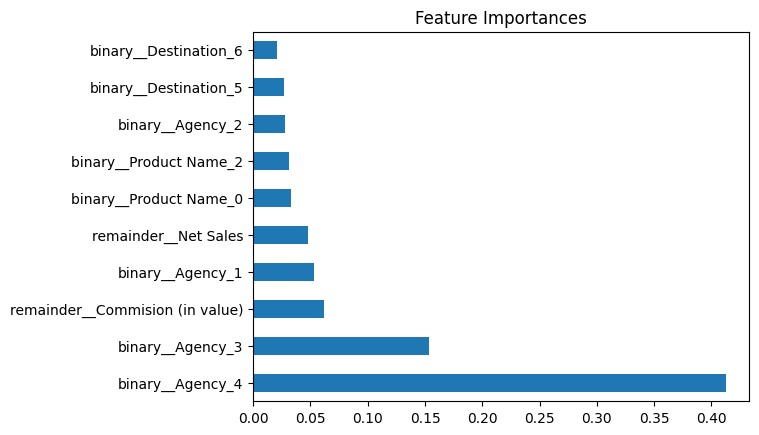

In [57]:
coef1 = pd.Series(best_model['model'].feature_importances_, transformer.get_feature_names_out()).sort_values(ascending = False).head(10)
coef1.plot(kind='barh', title='Feature Importances')
plt.show()

Terlihat bahwa ternyata untuk model XGBoost kita, fitur/kolom Agency adalah yang paling penting, kemudian diikuti dengan Commision (in value), Net Sales, dan selanjutnya.

## Conclusion & Recommendation

In [58]:
print('Classification Report Tuned LGBM : \n', report_tuned)

Classification Report Tuned LGBM : 
               precision    recall  f1-score   support

           0       0.99      0.82      0.90     12947
           1       0.06      0.69      0.11       203

    accuracy                           0.82     13150
   macro avg       0.53      0.76      0.50     13150
weighted avg       0.98      0.82      0.89     13150



Model kita dapat membaca 82% customer yang tidak melakukan claim asuransi, dan model kita dapat mendapatkan 69% customer yang melakukan claim asuransi. (semua ini berdasarkan recallnya)

Model kit ini memiliki ketepatan prediksi customer yang melakukan claim asuransi sebesar 0.06% (precisionnya). Angka tersebut dapat terbilang kecil untuk precision, hal ini akan kita perbaiki di kesempatan berikutnya dengan penambahan kolom/fitur yang lebih berhubungan dengan customer melakukan claim asuransi atau tidak.

Dikarenakan pencairan asuransi berbeda-beda, tergantung produk yang diambil.
Untuk proses perhitungan kita asumsikan, 1x pencairan asuransi biaya yang dikeluarkan oleh perusahaan adalah 100 USD.
Anggap saja kita punya 100 customer maka :

Tanpa Model (semua customer kita asumsikan akan melakukan claim asuransi)
- Total Dana yang perlu disiapkan => 100 x 100 USD = 10.000 USD

Dengan Model (hanya customer yang diperkirakan melakukan claim asuransi)
- Total Dana yang perlu disiapkan => 69 x 100 = 6.900 USD

Berdasarkan contoh hitungan tersebut, terlihat bahwa dengan menggunakan model kita, maka perusahaan tersebut dapat menyimpan dana sebesar 31% untuk keperluan yang lain.

#### Recommendation

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi :
- Menambah banyaknya data customer yang melakukan claim asuransi
- Menambahkan fitur2 atau kolom2 baru yang kemungkinan bisa berhubungan dengan claim asuransi, seperti tanggal claim asuransi (untuk melihat ada atau tidak di bulan2 tertentu berkorelasi dengan banyaknya claim asuransi yang masuk) dan ID Customer (untuk melihat customer yang melakukan claim asuransi apakah new_customer atau customer lama yang sudah berlangganan travel asuransi)
- Menganalisa data-data yang model kita masih salah tebak untuk mengetahui alasannya dan karakteristiknya bagaimana.